In [10]:

import pymc3.distributions.transforms as tr
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import warnings

In [11]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.9.3
Running on ArviZ v0.10.0


In [6]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

In [7]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

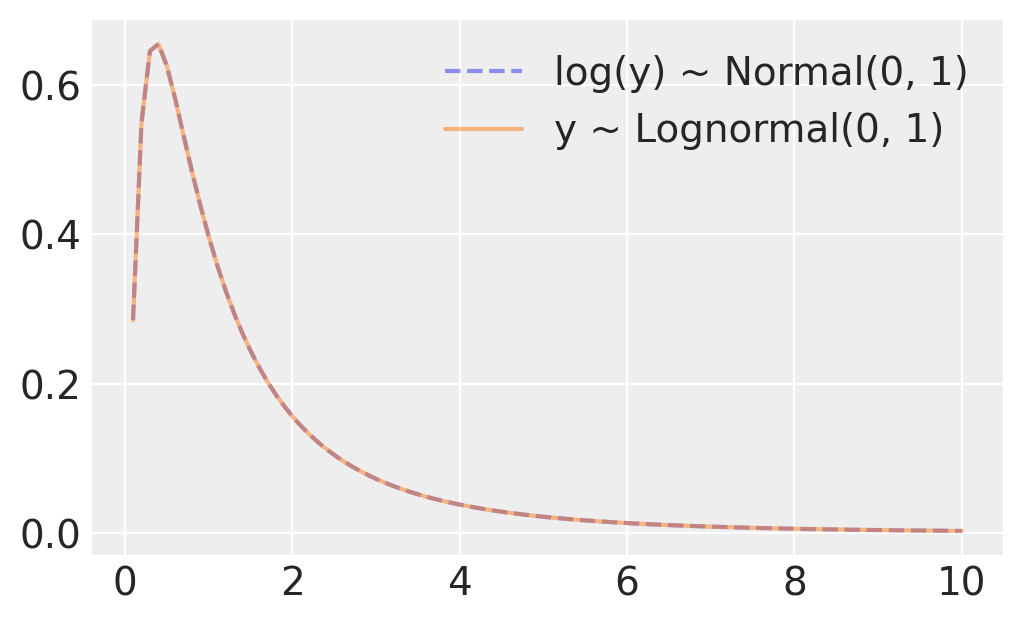

In [12]:
class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)


with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0.0, 10.0, 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha=0.5,
    label="log(y) ~ Normal(0, 1)",
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=0.5,
    label="y ~ Lognormal(0, 1)",
)
plt.legend();

In [13]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
chain_tran = tr.Chain([Logodd, Order])

with pm.Model() as m0:
    x = pm.Uniform("x", 0.0, 1.0, shape=2, transform=chain_tran, testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=False, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.705529150043806, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


C:\ProgramData\Anaconda3\envs\mcmc\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


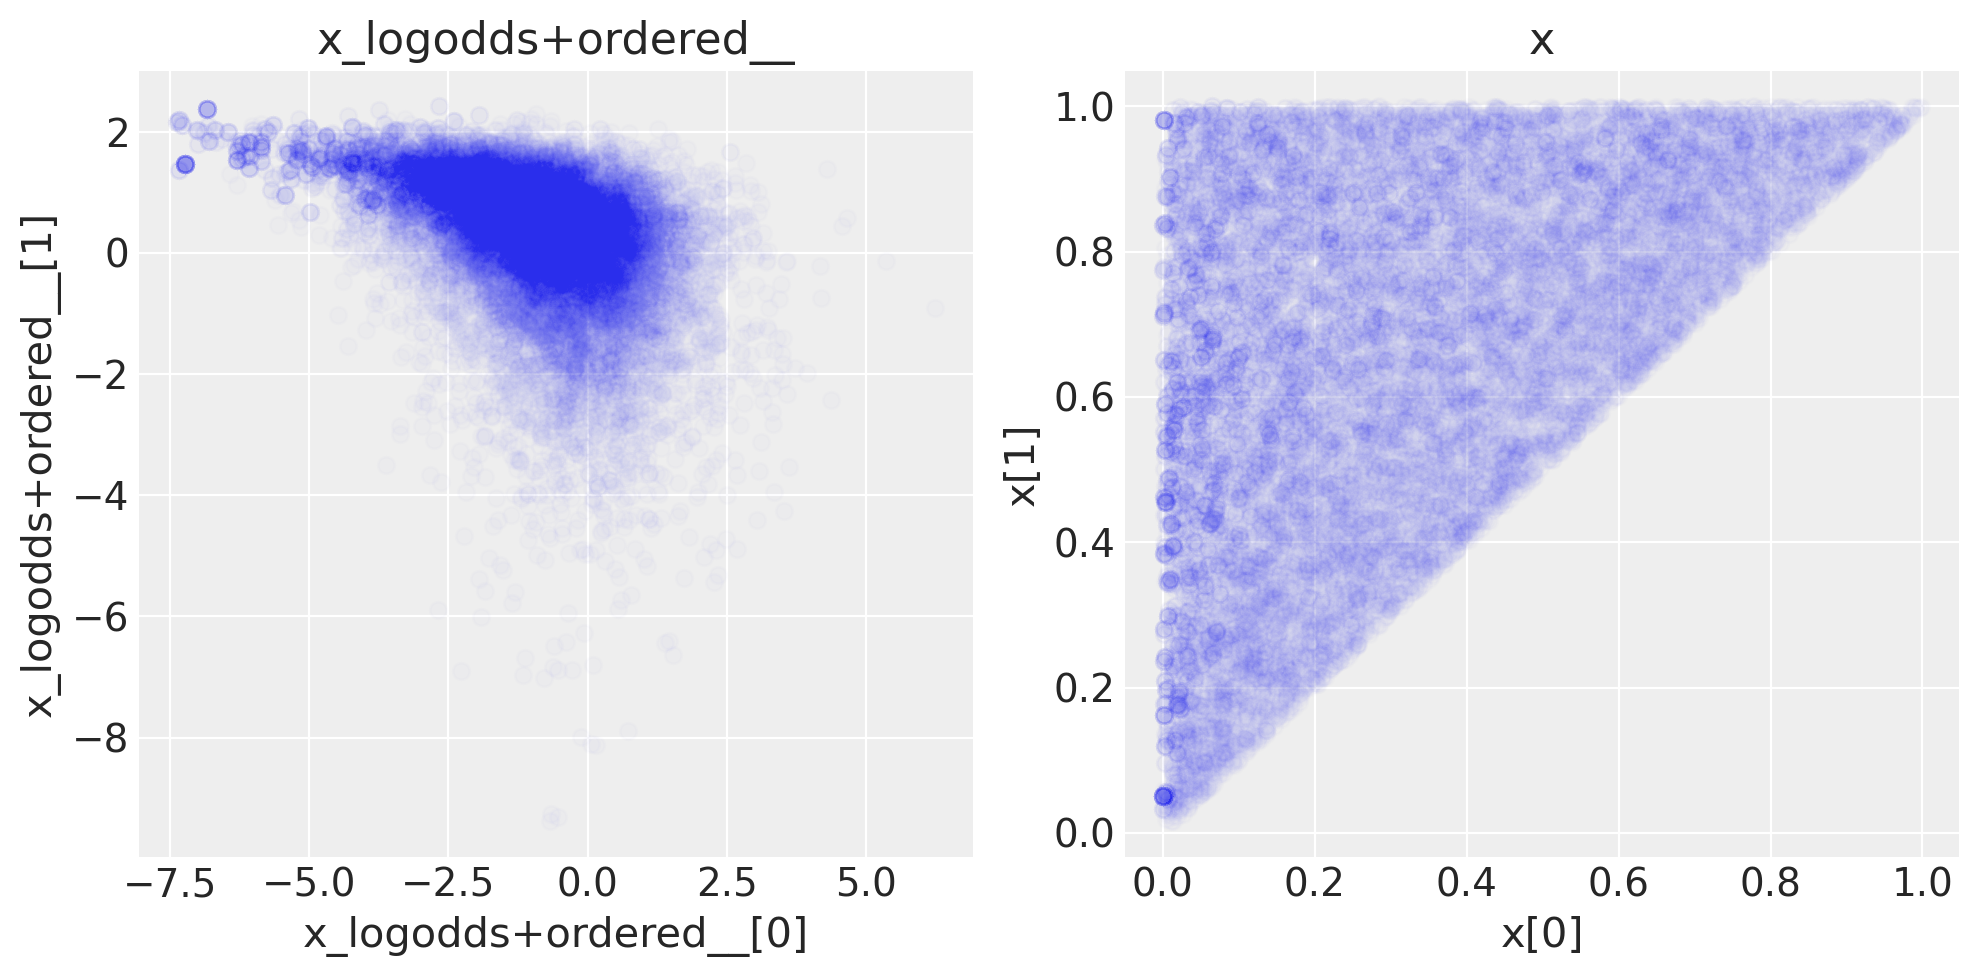

In [14]:

_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:, 0], trace[varname][:, 1], alpha=0.01)
    ax[ivar].set_xlabel(varname + "[0]")
    ax[ivar].set_ylabel(varname + "[1]")
    ax[ivar].set_title(varname)
plt.tight_layout()



In [15]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 310 seconds.
The number of effective samples is smaller than 25% for some parameters.


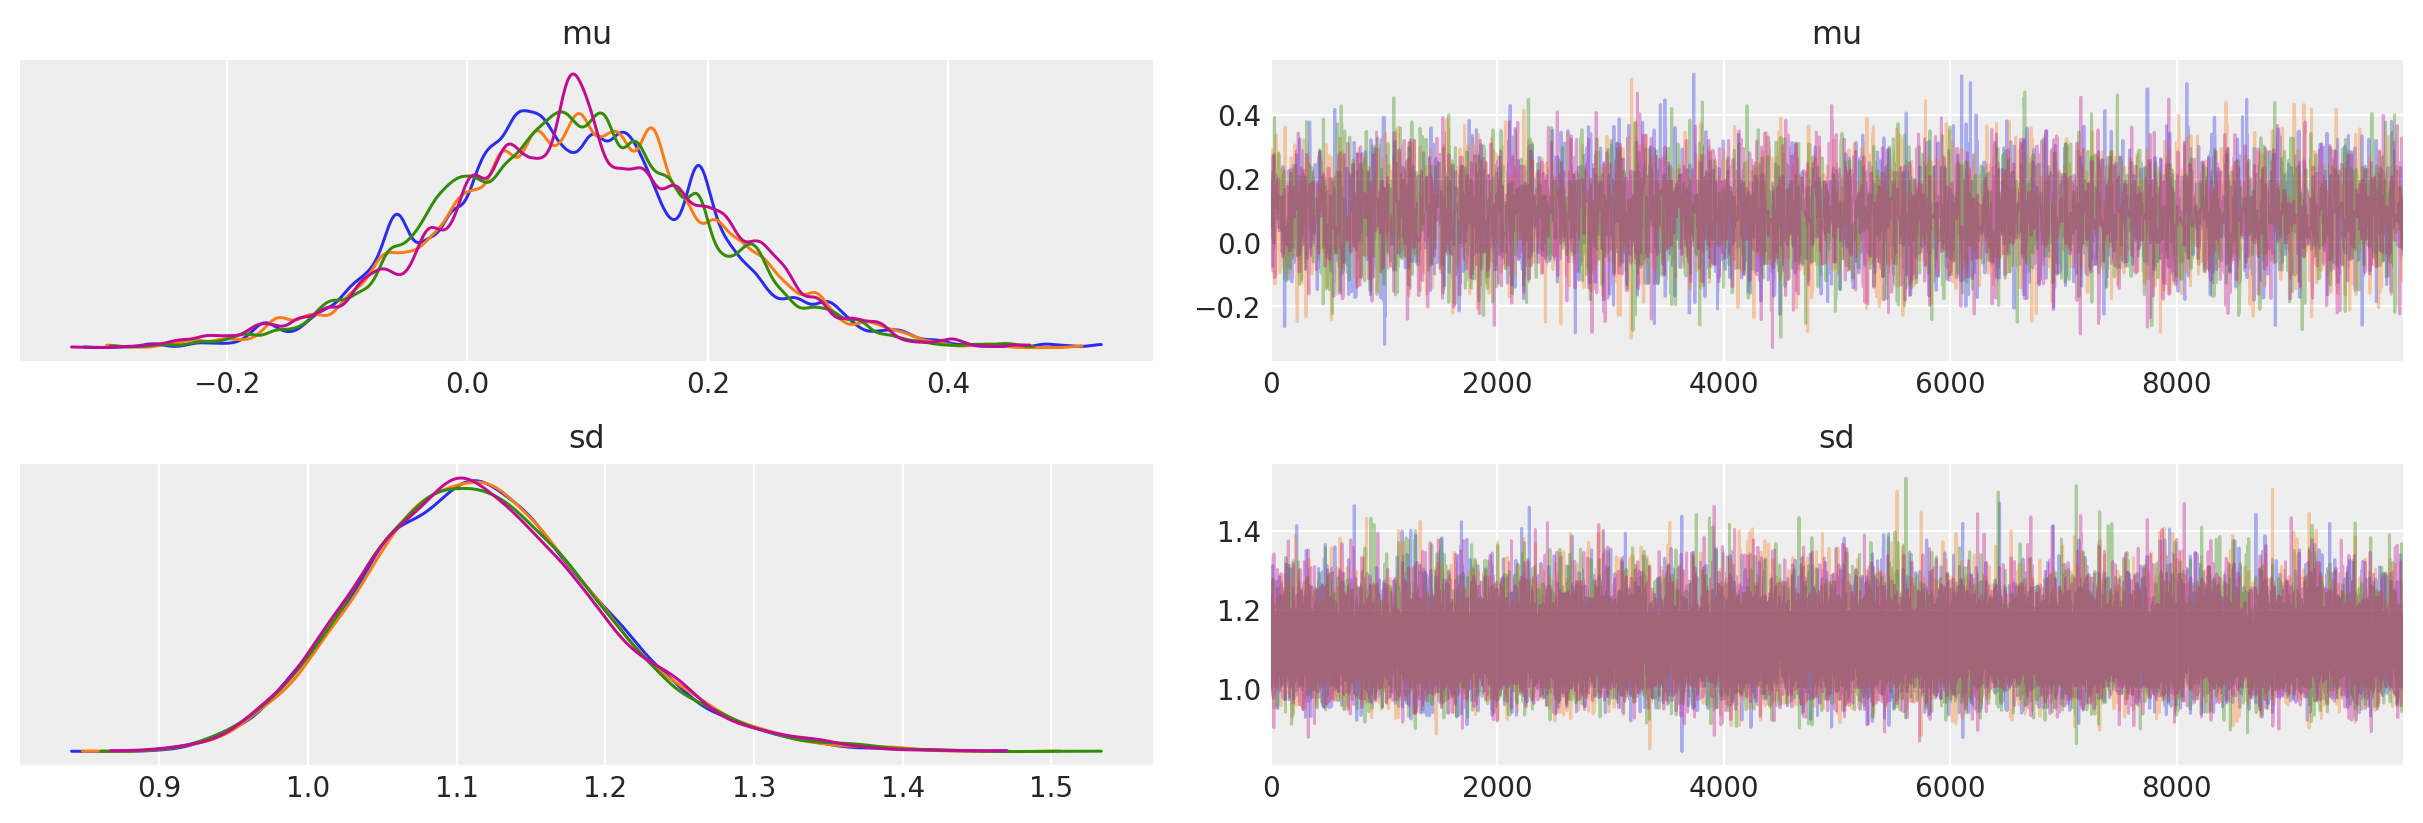

In [16]:
az.plot_trace(idata);

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.088,0.113,-0.121,0.305,0.001,0.001,6448.0,5435.0,6431.0,6568.0,1.0
sd,1.118,0.080,0.969,1.267,0.000,0.000,37341.0,36476.0,38209.0,27773.0,1.0


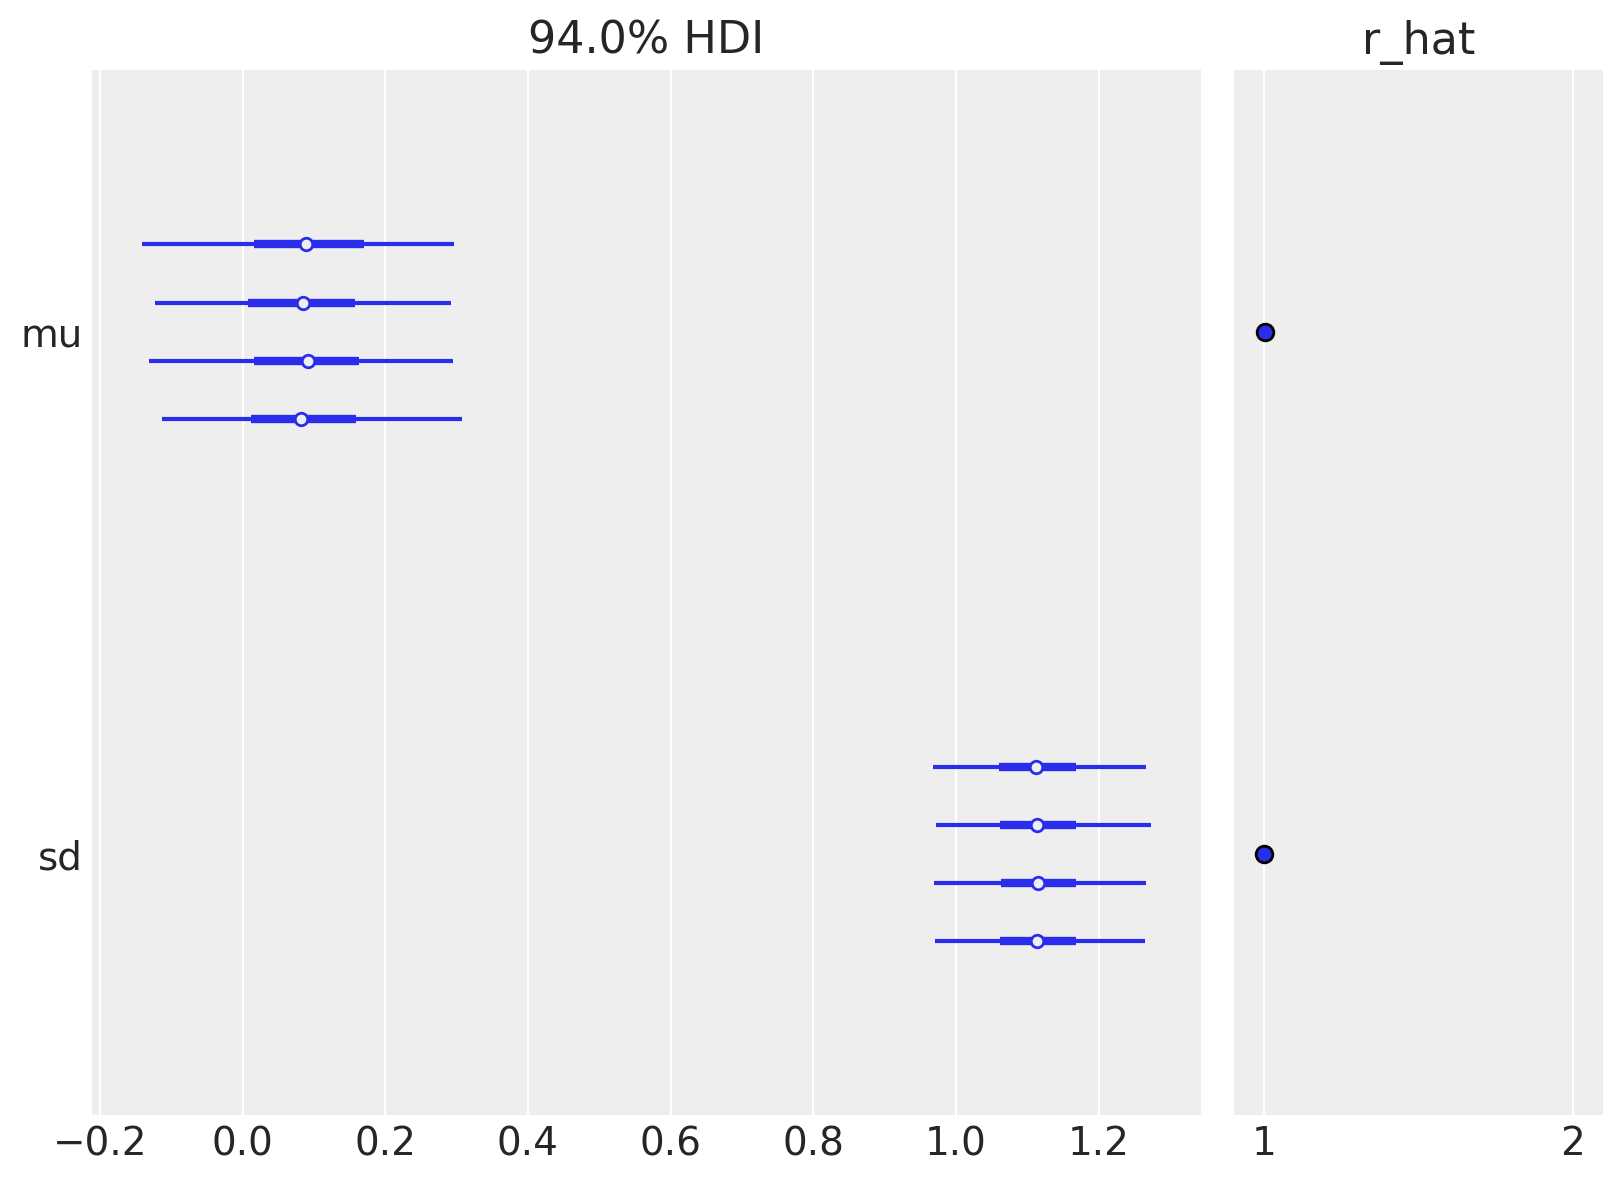

In [18]:
az.plot_forest(idata, r_hat=True);

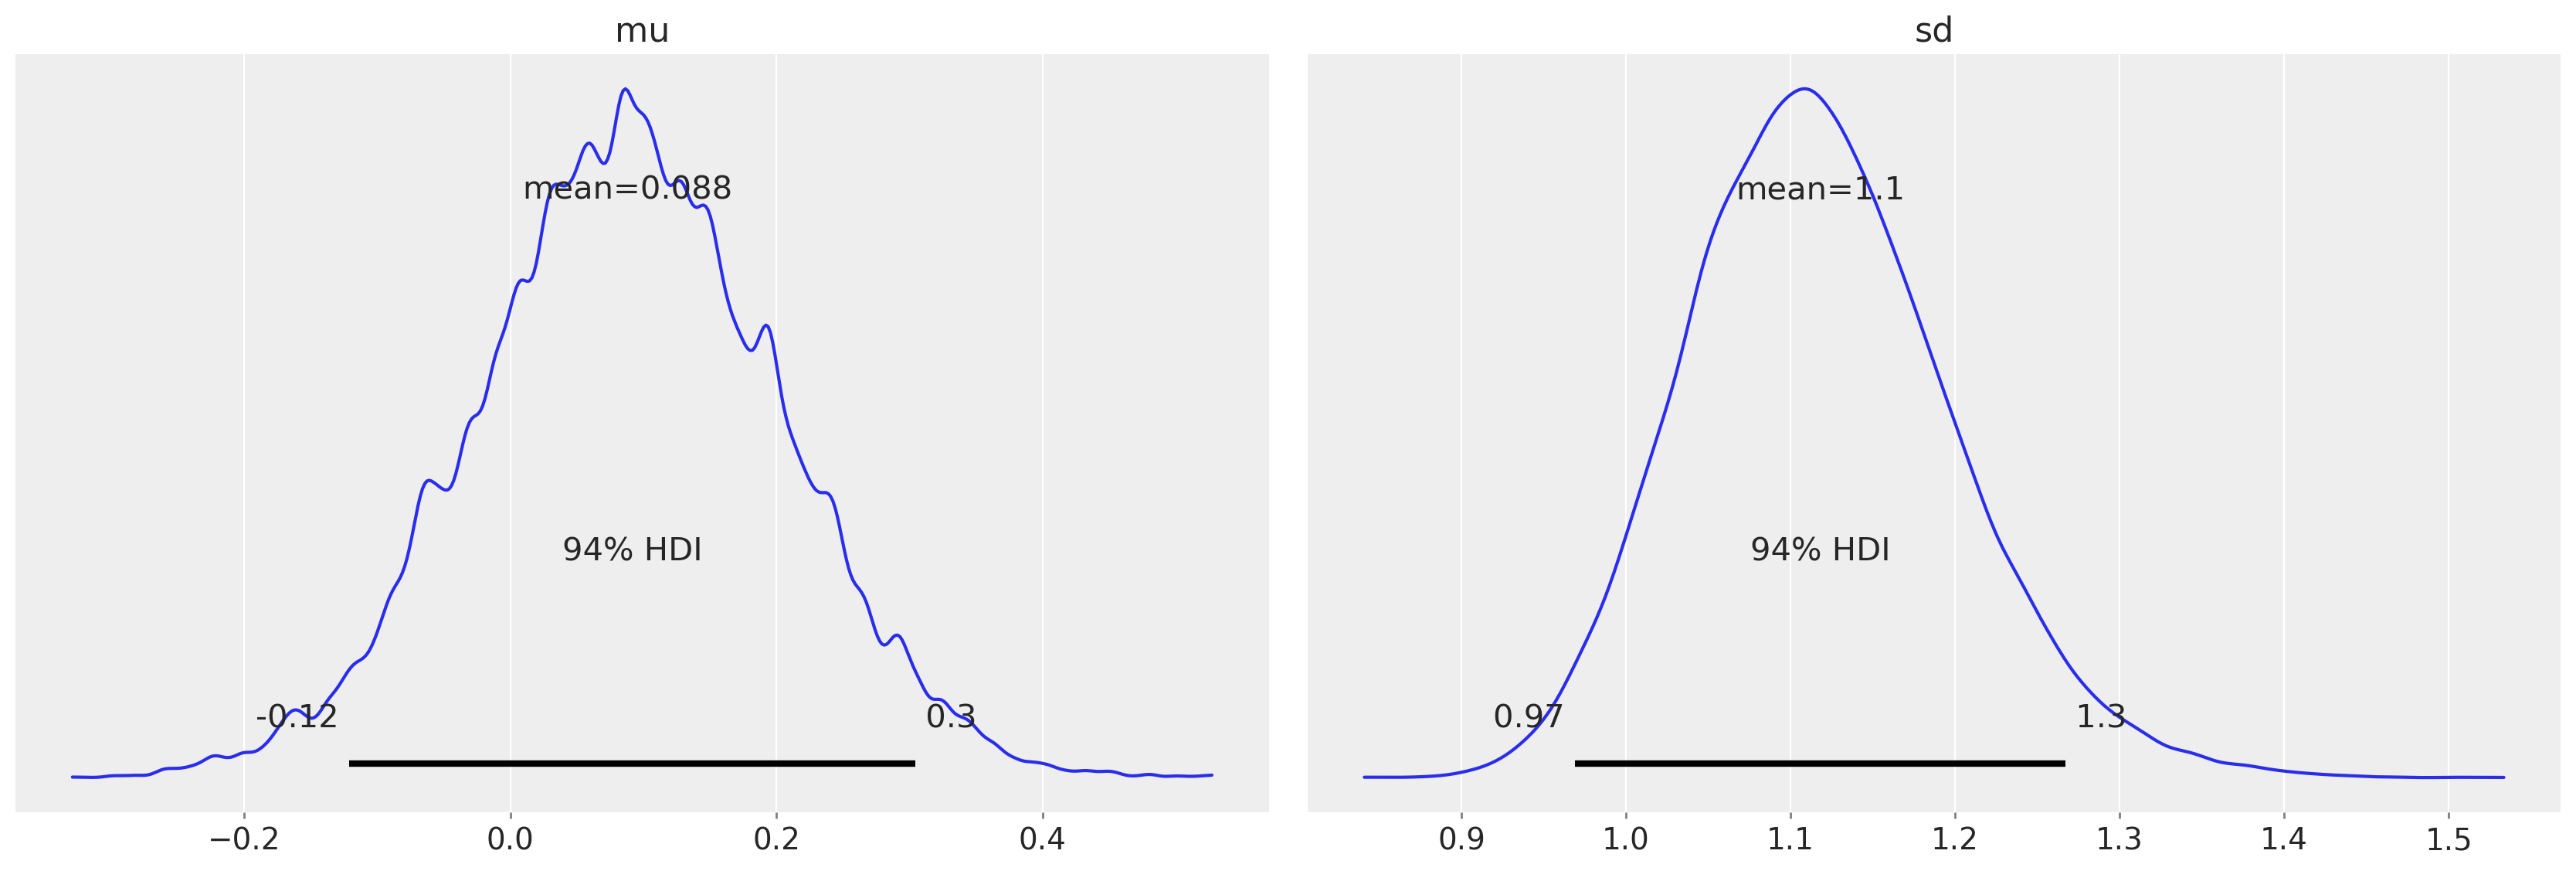

In [19]:
az.plot_posterior(idata);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


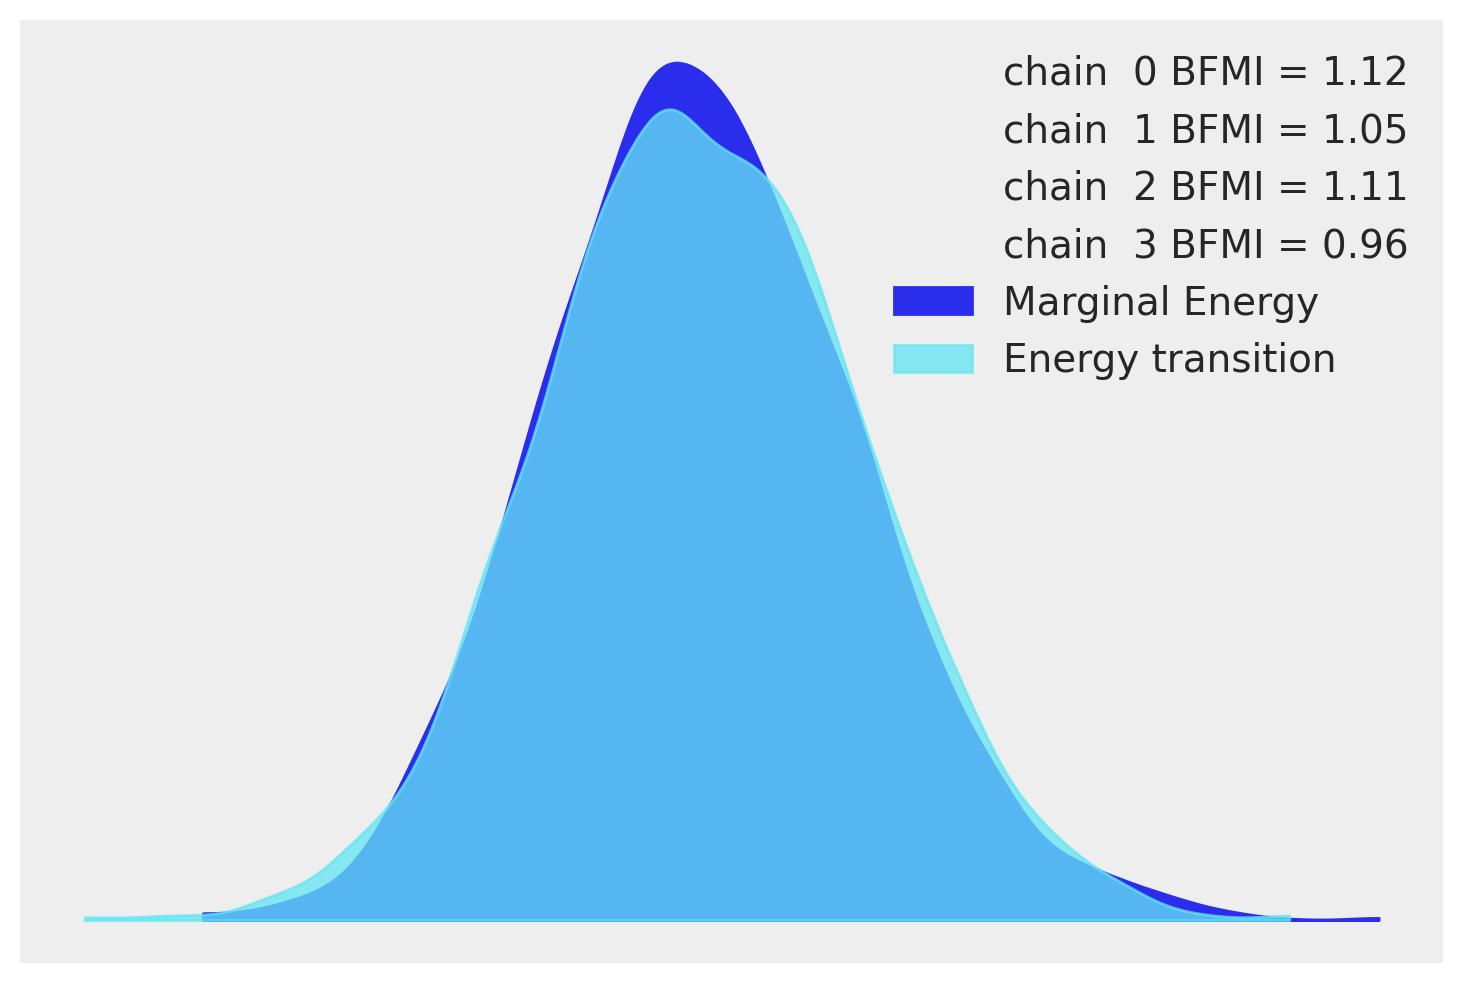

In [20]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=100)
    idata = pm.sample(cores=4, return_inferencedata=True)

az.plot_energy(idata);